# **Cryptocurrency Data Analysis and Forecasting**

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/comprehensive-cryptocurrency-market-data/crypto_trends_insights_2024.csv


In [3]:
# !pip install prophet

# **Section 1: Importing Necessary Libraries**

In [4]:
# Importing essential libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import plotly.express as px
import plotly.graph_objects as go
from prophet import Prophet
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from scipy.stats import zscore

import warnings
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')

# **Section 2: Reading Datasets and Initial Exploration**

In [5]:
# Loading the dataset
file_path = '/kaggle/input/comprehensive-cryptocurrency-market-data/crypto_trends_insights_2024.csv'
crypto_data = pd.read_csv(file_path)

crypto_data.head()

,Name,Symbol,Price,1h %,24h %,7d %,60d %,90d %,YTD %,Market Cap,Volume (24h),Volume Change (24h),Volume Change (30d),Circulating Supply,Total Supply,Max Supply,Num Market Pairs
0,Bitcoin,BTC,96183.612709,-0.582452,-1.406937,-6.098029,43.357862,50.760758,NaN,1.904383e+12,5.128441e+10,-46.4837,NaN,1.979945e+07,1.979945e+07,2.100000e+07,11849
1,Ethereum,ETH,3313.788191,-0.906492,-4.726532,-14.958048,26.799836,24.709903,NaN,3.991634e+11,3.126633e+10,-48.6213,NaN,1.204553e+08,1.204553e+08,NaN,9712
2,Tether USDt,USDT,0.999253,-0.020326,-0.027455,-0.035466,-0.002103,-0.076709,NaN,1.397684e+11,1.421387e+11,-41.9306,NaN,1.398728e+11,1.434401e+11,NaN,109588
3,XRP,XRP,2.188454,-2.185932,-5.350521,-10.121365,312.945320,270.081243,NaN,1.252942e+11,1.424509e+10,-45.1770,NaN,5.725238e+10,9.998681e+10,1.000000e+11,1485
4,BNB,BNB,651.685277,-1.337123,-5.012758,-8.951213,10.758367,9.719003,NaN,9.384770e+10,2.075789e+09,-31.4686,NaN,1.440077e+08,1.440077e+08,NaN,2315


In [6]:
crypto_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10422 entries, 0 to 10421
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Name                 10422 non-null  object 
 1   Symbol               10422 non-null  object 
 2   Price                10422 non-null  float64
 3   1h %                 10422 non-null  float64
 4   24h %                10422 non-null  float64
 5   7d %                 10422 non-null  float64
 6   60d %                10422 non-null  float64
 7   90d %                10422 non-null  float64
 8   YTD %                0 non-null      float64
 9   Market Cap           10422 non-null  float64
 10  Volume (24h)         10422 non-null  float64
 11  Volume Change (24h)  10422 non-null  float64
 12  Volume Change (30d)  0 non-null      float64
 13  Circulating Supply   10422 non-null  float64
 14  Total Supply         10422 non-null  float64
 15  Max Supply           7193 non-null  

In [7]:
missing_values = crypto_data.isnull().sum()
missing_values

Name                       0
Symbol                     0
Price                      0
1h %                       0
24h %                      0
7d %                       0
60d %                      0
90d %                      0
YTD %                  10422
Market Cap                 0
Volume (24h)               0
Volume Change (24h)        0
Volume Change (30d)    10422
Circulating Supply         0
Total Supply               0
Max Supply              3229
Num Market Pairs           0
dtype: int64

In [8]:
crypto_data.describe(include = 'all')

,Name,Symbol,Price,1h %,24h %,7d %,60d %,90d %,YTD %,Market Cap,Volume (24h),Volume Change (24h),Volume Change (30d),Circulating Supply,Total Supply,Max Supply,Num Market Pairs
count,10422,10422,1.042200e+04,10422.000000,10422.000000,1.042200e+04,1.042200e+04,1.042200e+04,0.0,1.042200e+04,1.042200e+04,1.042200e+04,0.0,1.042200e+04,1.042200e+04,7.193000e+03,10422.000000
unique,10227,8521,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,MAGA,TRUMP,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,10,32,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,9.453585e+06,-0.288289,0.641246,1.655411e+03,2.721187e+06,2.722664e+06,NaN,3.357221e+08,3.246243e+07,1.290656e+04,NaN,1.094196e+19,6.830891e+23,8.937838e+23,45.150163
std,NaN,NaN,9.650544e+08,10.974965,129.091132,1.562331e+05,2.663912e+08,2.663913e+08,NaN,1.921078e+10,1.524671e+09,1.265836e+06,NaN,1.117018e+21,6.332525e+25,7.580307e+25,1145.896493
min,NaN,NaN,0.000000e+00,-56.940285,-99.999018,-9.999984e+01,-1.000000e+02,-1.000000e+02,NaN,0.000000e+00,0.000000e+00,-1.000000e+02,NaN,0.000000e+00,0.000000e+00,0.000000e+00,1.000000
25%,NaN,NaN,5.360982e-05,-1.019994,-7.214286,-2.518977e+01,-3.531082e+01,-4.023521e+01,NaN,0.000000e+00,3.853050e+01,-5.339597e+01,NaN,0.000000e+00,8.581673e+07,1.000000e+08,3.000000
50%,NaN,NaN,1.897347e-03,-0.018832,-2.822792,-1.495760e+01,-2.093962e+00,-2.867345e+00,NaN,0.000000e+00,3.011039e+03,-1.330795e+01,NaN,0.000000e+00,9.994263e+08,1.000000e+09,6.000000
75%,NaN,NaN,4.800396e-02,0.000000,0.000000,-5.521332e+00,2.857897e+01,3.278379e+01,NaN,1.983793e+05,1.315338e+05,2.920000e-02,NaN,1.197753e+07,6.434709e+09,1.000000e+10,17.000000


# **Section 3: Data Cleaning and Preprocessing**

<Axes: >

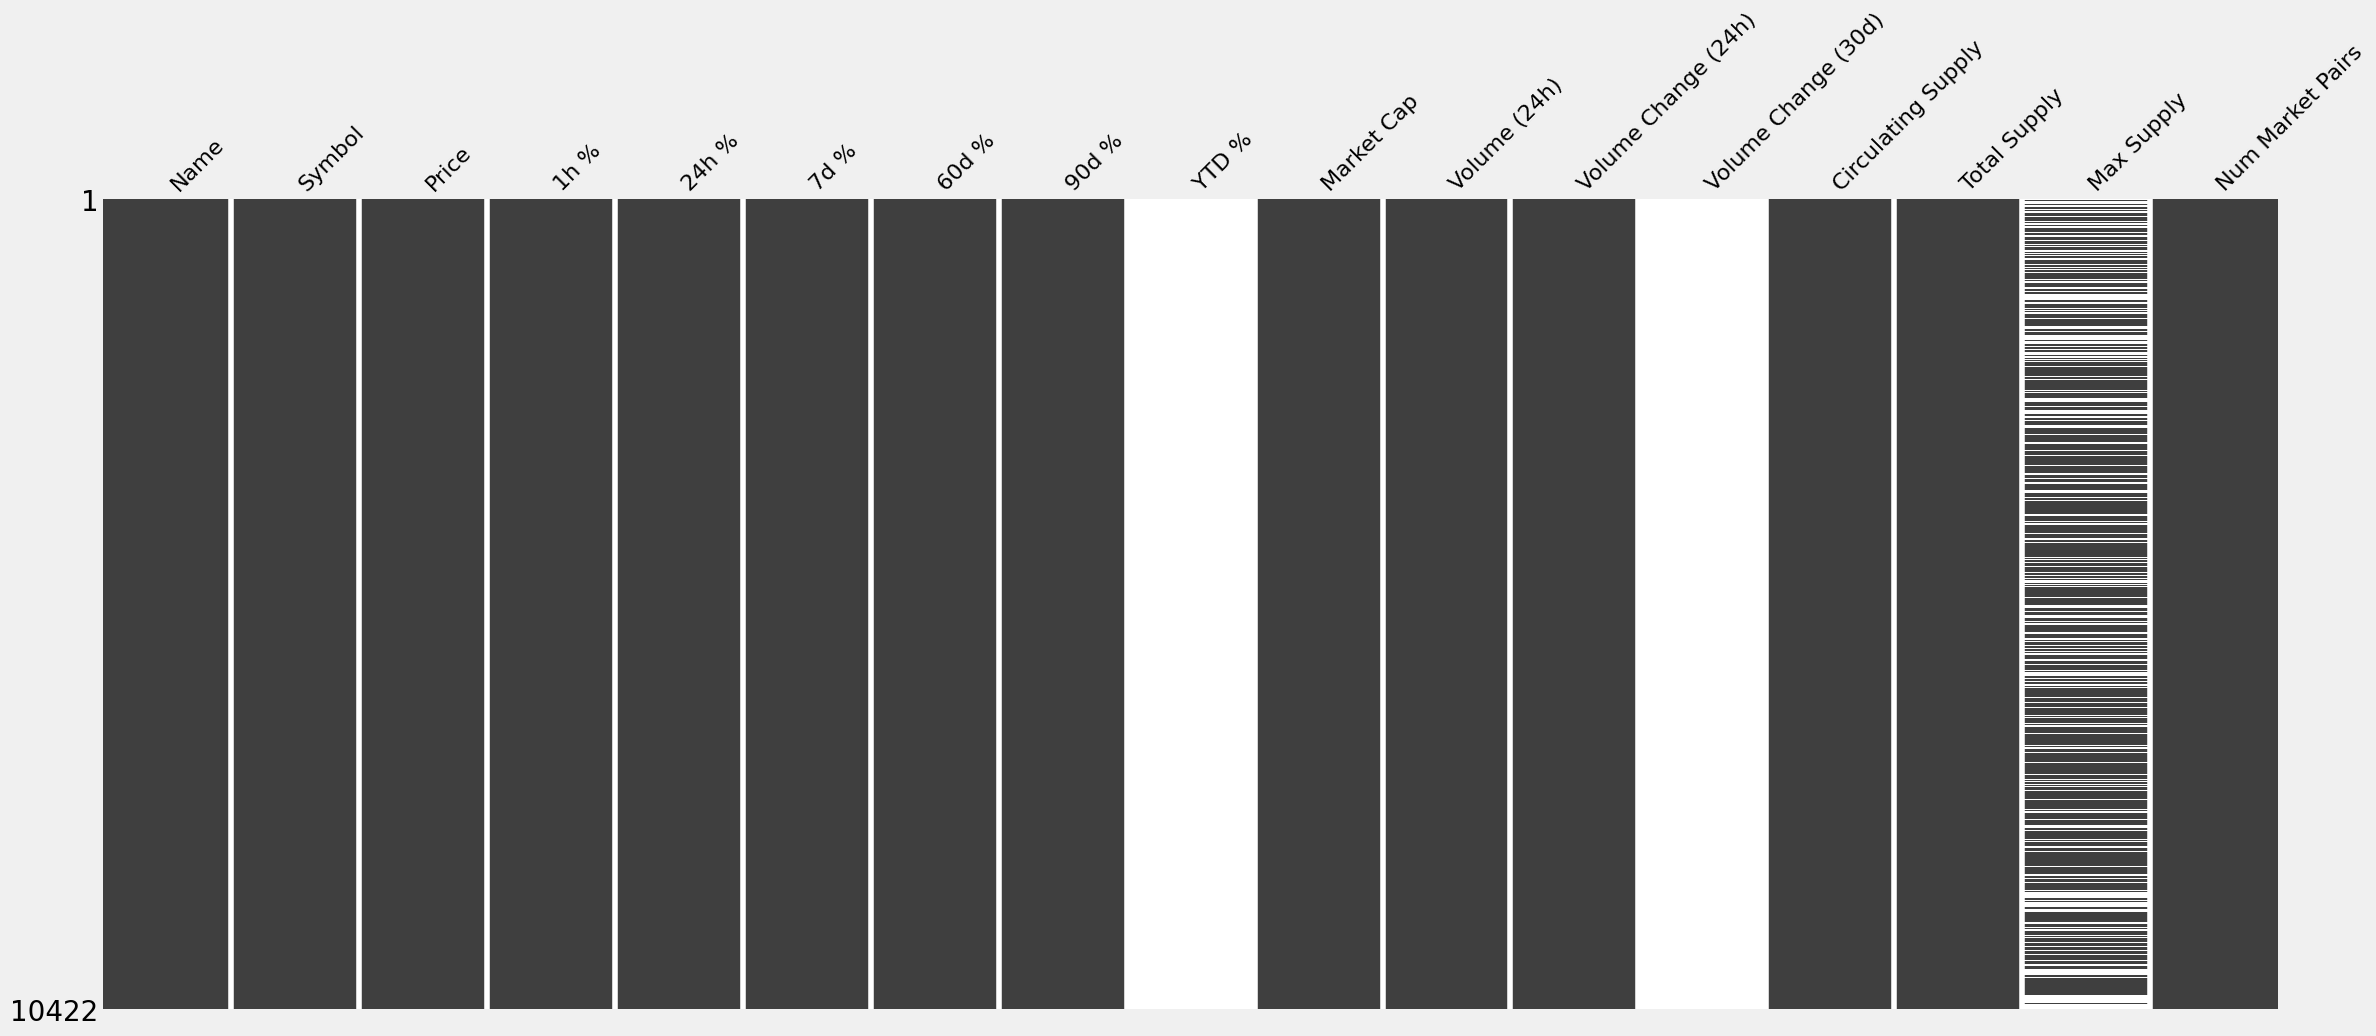

In [9]:
msno.matrix(crypto_data, sparkline=False)

In [10]:
# Dropping columns with excessive missing values
crypto_data.drop(columns=['YTD %', 'Volume Change (30d)'], inplace=True)

# Imputing missing values for 'Max Supply' with 'Total Supply' or set as 0
crypto_data['Max Supply'].fillna(crypto_data['Total Supply'], inplace=True)
crypto_data['Max Supply'].fillna(0, inplace=True)  # Use 0 for cryptocurrencies with no defined max supply

crypto_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10422 entries, 0 to 10421
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Name                 10422 non-null  object 
 1   Symbol               10422 non-null  object 
 2   Price                10422 non-null  float64
 3   1h %                 10422 non-null  float64
 4   24h %                10422 non-null  float64
 5   7d %                 10422 non-null  float64
 6   60d %                10422 non-null  float64
 7   90d %                10422 non-null  float64
 8   Market Cap           10422 non-null  float64
 9   Volume (24h)         10422 non-null  float64
 10  Volume Change (24h)  10422 non-null  float64
 11  Circulating Supply   10422 non-null  float64
 12  Total Supply         10422 non-null  float64
 13  Max Supply           10422 non-null  float64
 14  Num Market Pairs     10422 non-null  int64  
dtypes: float64(12), int64(1), object(2)


In [11]:
zero_market_cap = crypto_data[crypto_data['Market Cap'] == 0]
crypto_data['Market Cap'] = crypto_data['Market Cap'].replace(0, 1e-6)

print("Cryptocurrencies with 0 Market Cap:\n", zero_market_cap[['Name', 'Market Cap', 'Volume (24h)']])
print(f"\nTotal count of cryptocurrencies with 0 Market Cap: {len(zero_market_cap)}")

Cryptocurrencies with 0 Market Cap:
                            Name  Market Cap  Volume (24h)
2899   Tether USD Bridged ZED20         0.0  5.137762e+08
2900     Ethereum Bridged ZED20         0.0  4.855016e+08
2901                   SUNBEANS         0.0  9.114742e+07
2902                       FOMO         0.0  8.314989e+07
2903                   KingDeFi         0.0  6.846036e+07
...                         ...         ...           ...
10245                   Phicoin         0.0  0.000000e+00
10246          Magic Eden Ether         0.0  0.000000e+00
10247                  Cult AGI         0.0  0.000000e+00
10420               Staked NEAR         0.0  1.796745e+05
10421      Merlin Chain (M-BTC)         0.0  7.324676e+03

[7351 rows x 3 columns]

Total count of cryptocurrencies with 0 Market Cap: 7351


## Feature Engineering


In [12]:
# Adding a Volatility column
crypto_data['Volatility'] = crypto_data[['1h %', '24h %', '7d %']].std(axis=1)

# Adding a Liquidity Index column
crypto_data['Liquidity Index'] = crypto_data['Volume (24h)'] / crypto_data['Market Cap']

crypto_data.head()

,Name,Symbol,Price,1h %,24h %,7d %,60d %,90d %,Market Cap,Volume (24h),Volume Change (24h),Circulating Supply,Total Supply,Max Supply,Num Market Pairs,Volatility,Liquidity Index
0,Bitcoin,BTC,96183.612709,-0.582452,-1.406937,-6.098029,43.357862,50.760758,1.904383e+12,5.128441e+10,-46.4837,1.979945e+07,1.979945e+07,2.100000e+07,11849,2.975111,0.026930
1,Ethereum,ETH,3313.788191,-0.906492,-4.726532,-14.958048,26.799836,24.709903,3.991634e+11,3.126633e+10,-48.6213,1.204553e+08,1.204553e+08,1.204553e+08,9712,7.265476,0.078330
2,Tether USDt,USDT,0.999253,-0.020326,-0.027455,-0.035466,-0.002103,-0.076709,1.397684e+11,1.421387e+11,-41.9306,1.398728e+11,1.434401e+11,1.434401e+11,109588,0.007574,1.016959
3,XRP,XRP,2.188454,-2.185932,-5.350521,-10.121365,312.945320,270.081243,1.252942e+11,1.424509e+10,-45.1770,5.725238e+10,9.998681e+10,1.000000e+11,1485,3.994719,0.113693
4,BNB,BNB,651.685277,-1.337123,-5.012758,-8.951213,10.758367,9.719003,9.384770e+10,2.075789e+09,-31.4686,1.440077e+08,1.440077e+08,1.440077e+08,2315,3.807801,0.022119


In [13]:
# Identify rows with infinite values
inf_rows = crypto_data[crypto_data['Liquidity Index'] == np.inf]
print("Rows with infinite Liquidity Index:\n", inf_rows)

Rows with infinite Liquidity Index:
 Empty DataFrame
Columns: [Name, Symbol, Price, 1h %, 24h %, 7d %, 60d %, 90d %, Market Cap, Volume (24h), Volume Change (24h), Circulating Supply, Total Supply, Max Supply, Num Market Pairs, Volatility, Liquidity Index]
Index: []


# **Section 4: Exploratory Data Analysis**

In [14]:
# Columns to analyze using KDE plots
kde_features = ['Price', 'Market Cap', 'Volume (24h)', 'Circulating Supply', 'Total Supply', 'Max Supply']

# Create KDE plots
kde_plots = {}

for feature in kde_features:
    fig = px.histogram(
        crypto_data,
        x=feature,
        title=f'Distribution and KDE of {feature}',
        marginal='violin',  # Adds KDE and Violin plot for density
        histnorm='density',
        nbins=30,
        template='plotly_white'
    )
    fig.update_layout(
        xaxis_title=feature,
        yaxis_title="Density",
        font=dict(size=14),
        margin=dict(l=50, r=50, t=50, b=50)
    )
    kde_plots[feature] = fig
    fig.show(renderer='iframe')

In [15]:
# Apply log transformation to selected columns to reduce skewness
log_features = ['Price', 'Market Cap', 'Volume (24h)', 'Circulating Supply', 'Total Supply', 'Max Supply', 'Liquidity Index']

for feature in log_features:
    crypto_data[f'Log_{feature}'] = np.log1p(crypto_data[feature])  # log1p handles zero values safely

crypto_data[[f'Log_{feature}' for feature in log_features]].head()

,Log_Price,Log_Market Cap,Log_Volume (24h),Log_Circulating Supply,Log_Total Supply,Log_Max Supply,Log_Liquidity Index
0,11.474025,28.275179,24.660653,16.801165,16.801165,16.860033,0.026573
1,8.106149,26.712637,24.165808,18.606789,18.606789,18.606789,0.075413
2,0.692774,25.663252,25.680069,25.663999,25.689184,25.689184,0.701591
3,1.159536,25.553930,23.379678,24.770735,25.328304,25.328436,0.107682
4,6.481095,25.264939,21.453607,18.785377,18.785377,18.785377,0.021878


In [16]:
log_kde_features = [f'Log_{feature}' for feature in log_features]

for feature in log_kde_features:
    fig = px.histogram(
        crypto_data,
        x=feature,
        title=f'Distribution and KDE of {feature}',
        marginal='violin', 
        histnorm='density',
        nbins=30,
        template='plotly_white'
    )
    
    fig.update_layout(
        xaxis_title=feature,
        yaxis_title="Density",
        font=dict(size=14),
        margin=dict(l=50, r=50, t=50, b=50)
    )
    
    fig.show(renderer='iframe')

In [17]:
numerical_features = crypto_data.select_dtypes(include=['float64', 'int64']).columns
correlation_matrix = crypto_data[numerical_features].corr()

fig = px.imshow(
    correlation_matrix,
    title="Correlation Matrix of Numerical Features",
    labels=dict(color="Correlation"),
    color_continuous_scale="viridis", 
    text_auto=".2f" 
)

fig.update_layout(
    font=dict(size=12),
    margin=dict(l=50, r=50, t=50, b=50)
)

fig.show(renderer='iframe')

In [18]:
crypto_data['Diff_60d_90d'] = crypto_data['90d %'] - crypto_data['60d %']

fig = go.Figure()

fig.add_trace(go.Scatter(
    y=crypto_data['Diff_60d_90d'],
    mode='lines',
    name='Difference (90d% - 60d%)', 
    line=dict(color='blue')
))

fig.add_trace(go.Scatter(
    x=[0, len(crypto_data) - 1], 
    y=[0, 0],
    mode='lines',
    name='Zero Difference', 
    line=dict(color='red', dash='dash')
))

fig.update_layout(
    title="Difference Between 90d% and 60d% Over Samples",
    xaxis_title="Sample Index",
    yaxis_title="Difference (90d% - 60d%)",
    legend=dict(
        title="Legend", 
        orientation="h",
        yanchor="bottom",
        y=1.02,
        xanchor="right",
        x=1
    ),
    template="plotly_white",
)

fig.show(renderer='iframe')

In [19]:
large_positive_diff = crypto_data[crypto_data['Diff_60d_90d'] > 1000000]
large_negative_diff = crypto_data[crypto_data['Diff_60d_90d'] < -1000000]

print("Cryptocurrencies with Large Positive Differences:")
print(large_positive_diff[['Name', 'Diff_60d_90d']])

print("\nCryptocurrencies with Large Negative Differences:")
print(large_negative_diff[['Name', 'Diff_60d_90d']])

fig = px.histogram(
    crypto_data,
    x='Diff_60d_90d',
    title="Distribution of Differences Between 90d% and 60d%",
    marginal='box',
    nbins=30,
    template='plotly_white',
    hover_data=['Name']
)

fig.update_layout(
    xaxis_title="Difference (90d% - 60d%)",
    yaxis_title="Frequency",
)

fig.show(renderer='iframe')

Cryptocurrencies with Large Positive Differences:
                    Name  Diff_60d_90d
3360              PepeAI  9.629453e+06
6604      Ponzio The Cat  1.054361e+07
6724  Royal Finance Coin  3.822145e+06
9508             Jot Art  1.078011e+06

Cryptocurrencies with Large Negative Differences:
                   Name  Diff_60d_90d
3683          BSC Layer -7.261709e+06
8714  ELON BUYS TWITTER -3.519559e+06


In [20]:
top_10_crypto = crypto_data.nlargest(10, 'Market Cap')

market_cap_min = np.log10(top_10_crypto['Market Cap'].min()) - 0.5
market_cap_max = np.log10(top_10_crypto['Market Cap'].max()) + 0.5

price_min = np.log10(top_10_crypto['Price'].min()) - 0.5
price_max = np.log10(top_10_crypto['Price'].max()) + 0.5

fig = px.scatter(
    top_10_crypto,
    x='Market Cap',
    y='Price',
    size='Market Cap', 
    color='Name', 
    hover_name='Name', 
    title='Market Cap vs Price (Top 10 Cryptocurrencies)',
    log_x=True, 
    log_y=True,  
    template='plotly_white'
)

fig.update_layout(
    xaxis=dict(
        title="Market Cap (Log Scale)",
        range=[market_cap_min, market_cap_max],  
    ),
    yaxis=dict(
        title="Price (Log Scale)",
        range=[price_min, price_max],
    ),
)

fig.show(renderer='iframe')

In [21]:
top_10_crypto = crypto_data.nlargest(10, 'Market Cap')

fig = px.scatter(
    top_10_crypto,
    x='Liquidity Index',
    y='Volatility',
    size='Market Cap',
    color='Name',
    hover_name='Name', 
    title='Liquidity Index vs Volatility (Top 10 Cryptocurrencies)',
    log_x=True,  
    template='plotly_white'
)

fig.update_layout(
    xaxis_title="Liquidity Index (Log Scale)",
    yaxis_title="Volatility",
)

fig.show(renderer='iframe')

In [22]:
fig = px.scatter(
    top_10_crypto,
    x='Num Market Pairs',
    y='Volume (24h)',
    size='Market Cap',  
    color='Name',  
    hover_name='Name', 
    title='Volume (24h) vs Num Market Pairs (Top 10 Cryptocurrencies)',
    log_x=True,  
    log_y=True,  
    template='plotly_white'
)

fig.update_layout(
    xaxis_title="Num Market Pairs (Log Scale)",
    yaxis_title="Volume (24h) (Log Scale)",
)

fig.show(renderer='iframe')

In [23]:
price_change_cols = ["1h %", "24h %", "7d %", "60d %", "90d %"]

for col in price_change_cols:
    crypto_data[col] = pd.to_numeric(crypto_data[col], errors='coerce')

data_cleaned = crypto_data.dropna(subset=price_change_cols)

for col in price_change_cols:
    fig = px.histogram(
        data_cleaned, 
        x=col, 
        nbins=30, 
        title=f"Distribution of {col}", 
        marginal="box", 
    )
    fig.update_layout(xaxis_title="Percentage Change", yaxis_title="Frequency")
    fig.show(renderer='iframe')

In [24]:
cumulative_data = crypto_data[["1h %", "24h %", "7d %", "60d %", "90d %"]].cumsum()

fig = go.Figure()

for col in cumulative_data.columns:
    fig.add_trace(go.Scatter(
        x=cumulative_data.index,
        y=cumulative_data[col],
        mode='lines',
        name=col,
    ))

fig.update_layout(
    title="Cumulative Percentage Change Over Time",
    xaxis_title="Index",
    yaxis_title="Cumulative % Change",
    legend_title="Metrics",
    template='plotly_white'
)

fig.show(renderer='iframe')

In [25]:
numeric_columns = crypto_data.select_dtypes(include=['number']).columns
features = crypto_data[numeric_columns].drop(columns=["Price"], errors="ignore")
target = crypto_data["Price"]

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.3, random_state=42)

model = RandomForestRegressor(n_estimators = 300, random_state=42)
model.fit(X_train, y_train)

importance = model.feature_importances_
feature_importance_df = pd.DataFrame({"Feature": features.columns, "Importance": importance})
feature_importance_df = feature_importance_df.sort_values(by="Importance", ascending=False)

fig = px.bar(
    feature_importance_df, 
    x="Importance", 
    y="Feature", 
    orientation='h', 
    title="Feature Importance for Price Prediction",
    template='plotly_white'
)

fig.update_layout(xaxis_title="Importance Score", yaxis_title="Features")
fig.show(renderer = 'iframe')

In [26]:
outlier_columns = ["Price", "Market Cap", "Volume (24h)"]
z_scores = crypto_data[outlier_columns].apply(zscore)

outliers = (z_scores.abs() > 3).any(axis=1)
outlier_data = crypto_data[outliers]

fig = px.box(
    crypto_data, 
    y=outlier_columns, 
    title="Box Plot for Outlier Detection in Key Metrics",
    template='plotly_white'
)
fig.update_layout(yaxis_title="Values", xaxis_title="Metrics")
fig.show(renderer = 'iframe')

# **Section 5: Clustering Analysis of Cryptocurrencies**

In [27]:
relevant_features = ["Price", "Market Cap", "7d %", "24h %", "Volume (24h)"]
data_relevant = crypto_data[relevant_features].dropna()

scaler = StandardScaler()
data_relevant_scaled = scaler.fit_transform(data_relevant)

# Elbow Method
inertia = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(data_relevant_scaled)
    inertia.append(kmeans.inertia_)

fig = px.line(
    x=range(1, 11), 
    y=inertia, 
    labels={'x': 'Number of Clusters', 'y': 'Inertia'},
    title='Elbow Curve for Optimal Clusters'
)

fig.show(renderer='iframe')

In [28]:
optimal_k = 4  # Based on earlier analysis
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
clusters = kmeans.fit_predict(data_relevant_scaled)
crypto_data["Cluster"] = clusters

# Assign meaningful names to clusters based on domain knowledge or observed characteristics
cluster_names = {
    0: "High Volume Movers",
    1: "Stable Performers",
    2: "Low Market Cap",
    3: "Growth Opportunities",
}
crypto_data["Cluster Name"] = crypto_data["Cluster"].map(cluster_names)

fig = px.scatter_3d(
    x=data_relevant_scaled[:, 0], 
    y=data_relevant_scaled[:, 1], 
    z=data_relevant_scaled[:, 2],
    color=crypto_data["Cluster Name"],
    title="3D Visualization of Clusters with Meaningful Names",
    labels={'x': relevant_features[0], 'y': relevant_features[1], 'z': relevant_features[2]},
    color_discrete_sequence=px.colors.qualitative.Set1
)
fig.show(renderer = 'iframe')

# Evaluate clustering performance
silhouette_avg = silhouette_score(data_relevant_scaled, clusters)

cluster_centers_named = pd.DataFrame(
    scaler.inverse_transform(kmeans.cluster_centers_),
    columns=relevant_features
)
cluster_centers_named["Cluster Name"] = cluster_names.values()

In [29]:
silhouette_avg

0.9979722738741093

In [30]:
# Group cryptocurrencies by their assigned cluster and display them
cryptos_in_clusters = crypto_data.groupby("Cluster Name")["Name"].apply(list).reset_index()
cryptos_in_clusters.columns = ["Cluster Name", "Cryptocurrencies"]
cryptos_in_clusters

,Cluster Name,Cryptocurrencies
0,Growth Opportunities,[HODL]
1,High Volume Movers,"[Ethereum, Tether USDt, XRP, BNB, Solana, Doge..."
2,Low Market Cap,[Ponzio The Cat]
3,Stable Performers,[Bitcoin]
